In [2]:
import pandas as pd

In [3]:
data_path = './data/'


In [4]:
jeju_data6_df = pd.read_csv(data_path + 'KRI-DAC_Jeju_data6.txt')

FileNotFoundError: [Errno 2] No such file or directory: './data/KRI-DAC_Jeju_data6.txt'

In [42]:
# 데이터 정의

# YM	: 기준년월
# SIDO	: 지역대분류명
# SIGUNGU	: 지역중분류명
# FranClass	: 소상공인구분
# Type	: 업종명
# Time	: 시간대
# TotalSpent	: 총사용금액
# DisSpent	: 재난지원금 사용금액
# NumOfSpent	: 총 이용건수
# NumOfDisSpent	: 총 재난지원금 이용건수
# POINT_X, POINT_Y	: X,Y 좌표

jeju_data6_df.head()

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,1,1,202006,제주특별자치도,제주시,영세,일반한식,00시,502000,0,10,0,877005.9834,1.479766e+06
1,2,2,202006,제주특별자치도,제주시,영세,단란주점,00시,1520000,0,8,0,877005.7447,1.479816e+06
2,3,3,202006,제주특별자치도,제주시,중소1,편의점,00시,482310,0,35,0,877056.6756,1.479616e+06
3,4,4,202006,제주특별자치도,제주시,영세,편의점,00시,38050,5450,3,1,877055.9593,1.479766e+06
4,5,5,202006,제주특별자치도,제주시,영세,일반한식,00시,32000,32000,1,1,877055.4817,1.479866e+06


In [43]:
jeju_data6_df.loc[0]

OBJECTID                   1
Field1                     1
YM                    202006
SIDO                 제주특별자치도
SIGUNGU                  제주시
FranClass                 영세
Type                    일반한식
Time                     00시
TotalSpent            502000
DisSpent                   0
NumofSpent                10
NumofDisSpent              0
POINT_X          877005.9834
POINT_Y          1479766.073
Name: 0, dtype: object

## 좌표 변환

In [8]:
!pip install pyproj

     |████████████████████████████████| 7.5 MB 9.0 MB/s eta 0:00:01


In [44]:
from pyproj import Transformer

In [45]:
# crs: Coordinate Reference System
# from_crs(): Make transformer from crs 
# transform: point의 좌표 시스템을 변환해줌

# epsg:5179(UTM-K) - 네이버지도에서 사용 중인 좌표계 (한반도를 나타내기에 유용)
# epsg:4326(wgs84) - GPS에서 사용하는 좌표계 (전세계를 한번에 나타낼 때 유용)
transformer = Transformer.from_proj(Proj(init="EPSG:5179"),Proj(init="EPSG:4326"))

df_6 = jeju_data6_df.copy()
df_6['lon'], df_6['lat'] = transformer.transform(df_6['POINT_X'], df_6['POINT_Y'])

# transform한 type을 float64 -> str 로 변환
df_6['lon'] = df_6['lon'].astype(str)
df_6['lat'] = df_6['lat'].astype(str)

# 3. 중복 좌표 삭제 > url 생성 
df_6['lon_lat'] = df_6['lon']+'_'+df_6['lat']
df_uniq = df_6.drop_duplicates('lon_lat')
df_uniq.value_counts('lon_lat')

/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


lon_lat
126.16370558240443_33.33544861735468     1
126.55761354427582_33.44973654152321     1
126.55744392829351_33.264456198626455    1
126.55745133042375_33.26400547881826     1
126.55745873241018_33.263554759877884    1
                                        ..
126.48510753973808_33.47546908389631     1
126.4851545536666_33.472764947994555     1
126.48522506380449_33.468708740463306    1
126.48528772780519_33.46510322030796     1
126.96951006044938_33.49847009919259     1
Length: 13909, dtype: int64

# SETUP

In [5]:
import pandas as pd
from pyproj import Transformer, Proj
import requests
import json

data_path = '/.data/'
kakao_api_url_base = 'https://dapi.kakao.com'
kakao_api_url = kakao_api_url_base + '/v2/local/geo/coord2regioncode.json'
kakao_rest_api_key = 'e1fd8bd439cbf0e3afc7bd2b1f1f61f1'



In [3]:
# EPSG:4326 base 좌표값으로 카카오 API를 통해 주소 가져오기
def coor2region(x, y):
    headers = {"Authorization": 'KakaoAK ' + kakao_rest_api_key}
    params = {'x': x, 'y': y, 'input_coord': 'WGS84'}
    res = requests.get(kakao_api_url, headers=headers, params=params)
    return json.loads(res.text)


# 주소 데이터 가져오기

In [50]:
def get_addr_data(fn):
    # 파일을 불러와서 데이터를 가공한다. (주소 변환)
    # fn: file name, 제주도 월별 데이터 파일 이름
    
    raw_df = pd.read_csv(fn)
    
    transformer = Transformer.from_proj(Proj(init="EPSG:5179"),Proj(init="EPSG:4326"))

    df = raw_df.copy()
    df['lon'], df['lat'] = transformer.transform(df['POINT_X'], df['POINT_Y'])

    # transform한 type을 float64 -> str 로 변환
    df['lon'] = df['lon'].astype(str)
    df['lat'] = df['lat'].astype(str)

    # 중복 좌표 삭제 > url 생성 
    df['lon_lat'] = df['lon']+'_'+df['lat']
    df_uniq = df.drop_duplicates('lon_lat')
    df_uniq.value_counts('lon_lat')
    
    # 앞서 정의한 함수를 이용해서 좌표 -> 주소 변환
    # 변환하고 주소에서 '동' 만 가져오기
    # row당 약 7초 정도 걸림
    dong_list = []
    cnt = len(df_uniq) # 이건 그냥 얼마나 걸릴까 체크하는 용도
    for idx, row in df_uniq.iterrows():        
        if not cnt % 100: print(cnt)
        region = coor2region(row['lon'], row['lat'])
        dong = region['documents'][0]['region_3depth_name']
        dong_list.append(dong)
        cnt -= 1
        
#     기존 df에 주소 추가
    df_uniq['dong'] = dong_list
    return df_uniq

In [15]:
import os
data_path = 'data/'
data_file_names = os.listdir(os.getcwd() + '/' + data_path)

In [16]:
data_file_names

['KRI-DAC_Jeju_data6.txt',
 'KRI-DAC_Jeju_data7.txt',
 'KRI-DAC_Jeju_data5.txt',
 'KRI-DAC_Jeju_data8.txt']

In [17]:
months = []
uniq_file_prefix = 'jeju_uniq_data_'
for fn in data_file_names:
    month = fn[-5]
    months.append(month)

In [95]:
for fn in data_file_names:
    df = get_addr_data(data_path + fn)
    with open(f'{uniq_file_prefix}{month}.bin', 'wb') as f:
        pickle.dump(df, f)

/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


14000
13900
13800
13700
13600
13500
13400
13300
13200
13100
13000
12900
12800
12700
12600
12500
12400
12300
12200
12100
12000
11900
11800
11700
11600
11500
11400
11300
11200
11100
11000
10900
10800
10700
10600
10500
10400
10300
10200
10100
10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


<ipython-input-50-4e52e6e2bd02>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['dong'] = dong_list
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful 

13800
13700
13600
13500
13400
13300
13200
13100
13000
12900
12800
12700
12600
12500
12400
12300
12200
12100
12000
11900
11800
11700
11600
11500
11400
11300
11200
11100
11000
10900
10800
10700
10600
10500
10400
10300
10200
10100
10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


<ipython-input-50-4e52e6e2bd02>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['dong'] = dong_list
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful 

13900
13800
13700
13600
13500
13400
13300
13200
13100
13000
12900
12800
12700
12600
12500
12400
12300
12200
12100
12000
11900
11800
11700
11600
11500
11400
11300
11200
11100
11000
10900
10800
10700
10600
10500
10400
10300
10200
10100
10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


<ipython-input-50-4e52e6e2bd02>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_uniq['dong'] = dong_list


In [18]:
months

['6', '7', '5', '8']

In [37]:
import pickle

jeju_all = pd.DataFrame()
for m in months:
    print(m)
    with open(f'{uniq_file_prefix}{m}.bin', 'rb') as f:
        df = pickle.load(f)
        jeju_all = pd.concat([jeju_all, df])

6
7
5
8


In [38]:
jeju_all.shape

(55727, 20)

In [39]:
jeju_all.tail(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,X,Y
278934,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x시,110000,0,1,0,921003.9820,1.476178e+06,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,NaN,NaN
279537,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x시,50000,0,1,0,937500.1674,1.486053e+06,126.82818252032293,33.36422597166204,126.82818252032293_33.36422597166204,성산읍,NaN,NaN
279784,279785,279785,202008,제주특별자치도,제주시,영세,기타숙박업,x시,17470,0,2,0,941114.0531,1.503713e+06,126.86586853032782,33.52371304945294,126.86586853032782_33.52371304945294,구좌읍,NaN,NaN


In [40]:
jeju_cat = jeju_all['Type'].copy()

In [41]:
jeju_cat

0              일반한식
1              단란주점
2               편의점
3               편의점
4              일반한식
            ...    
275531         보습학원
275663    학원(회원제형태)
278934        예체능학원
279537         기타가구
279784        기타숙박업
Name: Type, Length: 55727, dtype: object

In [42]:
# 업종 Type -> Category로 분류
jeju_cat.replace(dict.fromkeys(['택시', '기타교통수단', '통신기기'], '교통/통신'), inplace=True)
jeju_cat.replace(dict.fromkeys(['대형할인점', '농축협직영매장', '농협하나로클럽', '편의점', '슈퍼마켓', '정육점', '기타유통업', '연쇄점', '상품권', '인삼제품', '홍삼제품', '농축수산품', '주류판매점', '기타건강식', '건강식품(회원제형태)'], '마트/편의점(유통)'), inplace=True)
jeju_cat.replace(dict.fromkeys(['악기점', 'DVD음반테이프판매', '문화취미기타', '영화관', '티켓', '수족관', '화랑'], '영화/문화'), inplace=True)
jeju_cat.replace(dict.fromkeys(['내의판매점', '양품점', '옷감직물', '귀금속', '기타직물', '스포츠의류', '가방', '정장', '악세사리', '기타잡화', '신발', '기타의류', '단체복', '아동의류', '캐쥬얼의류', '맞춤복점', '제화점', '인터넷Mall', '인터넷종합Mall'], '쇼핑/패션'), inplace=True)
jeju_cat.replace(dict.fromkeys(['제과점', '스넥', '기타음료식품'], '카페/베이커리'), inplace=True)
jeju_cat.replace(dict.fromkeys(['미용재료', '화장품', '피부미용실', '미용원', '이용원'], '뷰티'), inplace=True)
jeju_cat.replace(dict.fromkeys(['구내매점', '단란주점', '주점', '서양음식', '일반한식', '일식회집', '중국음식',  '유흥주점', '칵테일바'], '외식/주점'), inplace=True)
jeju_cat.replace(dict.fromkeys(['세탁소', '애완동물', '화원', '침구수예점', '성인용품점', '가전제품', '기타가구', '조명기구', '민예공예품', '주방용식기', '기타전기제품', '소프트웨어', '주방용구', '카페트커텐천막', '컴퓨터', '카메라', '일반가구', '정수기', '철제가구', '시계', '안경', '사우나', '안마스포츠마사지', '사진관', '인테리어', 'CATV'], '생활/기타'), inplace=True)
jeju_cat.replace(dict.fromkeys(['완구점', '화방표구점', '문구용품', '일반서적', '출판인쇄물', '기타사무용', '사무기기', '전문서적', '정기간행물', '기타서적문구', '서적출판(회원제형태)'], '서점/문구'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기타보험', '손해보험'], '금융'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기념품점', '기타숙박업', '특급호텔', '2급호텔', '1급호텔', '콘도', '렌트카', '관광여행', '항공사', '여객선', '면세점'], '여행/숙박'), inplace=True)
jeju_cat.replace(dict.fromkeys(['레져용품수리', '스포츠레져용품', '골프용품', '노래방', '당구장', '골프경기장', '볼링장', '골프연습장', '헬스크럽', '레져업소(회원제형태)', '기타레져업', '종합레져타운', '수영장', '테니스장', '기타회원제형태업소', ], '레저/스포츠'), inplace=True)
jeju_cat.replace(dict.fromkeys(['유아원', '독서실', '보습학원', '기능학원', '기타교육', '외국어학원', '학원(회원제형태)', '예체능학원', '컴퓨터학원', '대학등록금', '학습지교육', '초중고교육기관'], '교육/육아'), inplace=True)
jeju_cat.replace(dict.fromkeys(['주유소', '자동차정비', 'LPG', '세차장', '유류판매', '이륜차판매', '윤활유전문판매', '자동차시트타이어', '중고자동차', '수입자동차', '자동차부품', '주차장', '기타자동차서비스', '카인테리어', ], '주유/자동차'), inplace=True)
jeju_cat.replace(dict.fromkeys(['약국', '종합병원', '기타의료기관및기기', '한약방', '제약회사', '의료용품', '건강진단', '한의원', '동물병원', '의원', '치과의원', '병원', '산후조리원', '치과병원'], '의료'), inplace=True)
jeju_cat.replace(dict.fromkeys(['목재석재철물', '건축요업품', '골동품점', '기계공구', '기타건축자재', '보일러펌프', '페인트', '냉열기기', '유리', '과학기자재', '기타광학품', '기타연료', '중장비수리', ], '건설/제조'), inplace=True)
jeju_cat.replace(dict.fromkeys(['기타농업관련', '비료농약사료종자', '농기계', '미곡상'], '농업'), inplace=True)
jeju_cat.replace(dict.fromkeys(['사무서비스', '기타대인서비스', '화물운송', '보관창고업', '종합용역', '조세서비스', '가례서비스', '공공요금', '위탁급식업', '기타용역서비스', '기타수리서비스', '기타운송', '가정용품수리', '견인서비스', '부동산중개임대', '부동산분양', '신변잡화수리', '사무통신기기수리', '법률회계서비스', '사무서비스(회원제형태)', '정보서비스', '기타업종', '기타비영리유통'], '서비스/기타'), inplace=True)

In [44]:
jeju_all['Category'] = jeju_cat
jeju_all.drop(['X', 'Y'], axis=1, inplace=True)

In [45]:
jeju_all.tail(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category
278934,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x시,110000,0,1,0,921003.9820,1.476178e+06,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,교육/육아
279537,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x시,50000,0,1,0,937500.1674,1.486053e+06,126.82818252032293,33.36422597166204,126.82818252032293_33.36422597166204,성산읍,생활/기타
279784,279785,279785,202008,제주특별자치도,제주시,영세,기타숙박업,x시,17470,0,2,0,941114.0531,1.503713e+06,126.86586853032782,33.52371304945294,126.86586853032782_33.52371304945294,구좌읍,여행/숙박


In [47]:
import numpy as np
# 제주시 --동 > 제주시로 통일
cond1 = jeju_all['SIGUNGU'] == '제주시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

# 서귀포시 --동 > 서귀포시로 통일
cond1 = jeju_all['SIGUNGU'] == '서귀포시'
cond2 = jeju_all['dong'].str.contains('동')
jeju_all['dong_cat'] = np.where(jeju_all['dong'].str.contains('동'),jeju_all['SIGUNGU'], jeju_all['dong'])

jeju_all.tail(3)

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category,dong_cat
278934,278935,278935,202008,제주특별자치도,서귀포시,영세,예체능학원,x시,110000,0,1,0,921003.9820,1.476178e+06,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,교육/육아,남원읍
279537,279538,279538,202008,제주특별자치도,서귀포시,영세,기타가구,x시,50000,0,1,0,937500.1674,1.486053e+06,126.82818252032293,33.36422597166204,126.82818252032293_33.36422597166204,성산읍,생활/기타,성산읍
279784,279785,279785,202008,제주특별자치도,제주시,영세,기타숙박업,x시,17470,0,2,0,941114.0531,1.503713e+06,126.86586853032782,33.52371304945294,126.86586853032782_33.52371304945294,구좌읍,여행/숙박,구좌읍


In [48]:
# Time에 '시'를 제거해 줍니다.
jeju_all['Time']= jeju_all['Time'].str.replace('시', '')

# 시간을 큰 범위로 변화해 줍니다.
def time_cut(x):
    if '06'> x >='02':
        return '새벽'
    elif '11'> x >= '06':
        return '오전'
    elif '15' > x >= '11':
        return '점심'
    elif '18' > x >= '15':
        return '오후'
    elif  '22'> x >= '18':
        return '저녁'
    else:
        return '심야'

In [49]:
# 함수 적용
jeju_all['Time_cut'] = jeju_all['Time'].apply(time_cut)

jeju_all.loc[jeju_all['Time']=='x', 'Time_cut'] ='무승인거래'

In [50]:
with open('jeju_all.bin', 'wb') as f:
    pickle.dump(jeju_all, f)

### 여기서부터 데이터 불러오고 시작

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import folium
# from folium.plugins import MarkerCluster, MiniMap

import pickle

In [8]:
with open('jeju_all.bin', 'rb') as f:
    jeju_all = pickle.load(f)

In [9]:
jeju_all

,OBJECTID,Field1,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,...,NumofDisSpent,POINT_X,POINT_Y,lon,lat,lon_lat,dong,Category,dong_cat,Time_cut
0,1,1,202006,제주특별자치도,제주시,영세,외식/주점,00,502000,0,...,0,877005.9834,1.479766e+06,126.17889362710162,33.30231529076244,126.17889362710162_33.30231529076244,한경면,외식/주점,한경면,심야
1,2,2,202006,제주특별자치도,제주시,영세,외식/주점,00,1520000,0,...,0,877005.7447,1.479816e+06,126.17888426813494,33.302765922881875,126.17888426813494_33.302765922881875,한경면,외식/주점,한경면,심야
2,3,3,202006,제주특별자치도,제주시,중소1,마트/편의점(유통),00,482310,0,...,0,877056.6756,1.479616e+06,126.17945834265305,33.30097125427593,126.17945834265305_33.30097125427593,한경면,마트/편의점(유통),한경면,심야
3,4,4,202006,제주특별자치도,제주시,영세,마트/편의점(유통),00,38050,5450,...,1,877055.9593,1.479766e+06,126.17943027296923,33.302323149341944,126.17943027296923_33.302323149341944,한경면,마트/편의점(유통),한경면,심야
4,5,5,202006,제주특별자치도,제주시,영세,외식/주점,00,32000,32000,...,1,877055.4817,1.479866e+06,126.17941155823847,33.303224412837565,126.17941155823847_33.303224412837565,한경면,외식/주점,한경면,심야
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275531,275532,275532,202008,제주특별자치도,제주시,영세,교육/육아,x,200000,0,...,0,910239.7342,1.500966e+06,126.53369851534627,33.49678916515772,126.53369851534627_33.49678916515772,이도이동,교육/육아,제주시,무승인거래
275663,275664,275664,202008,제주특별자치도,제주시,영세,교육/육아,x,220000,0,...,0,910390.6274,1.500767e+06,126.535342658025,33.49500544163311,126.535342658025_33.49500544163311,이도이동,교육/육아,제주시,무승인거래
278934,278935,278935,202008,제주특별자치도,서귀포시,영세,교육/육아,x,110000,0,...,0,921003.9820,1.476178e+06,126.65174159048293,33.27407883370635,126.65174159048293_33.27407883370635,남원읍,교육/육아,남원읍,무승인거래
279537,279538,279538,202008,제주특별자치도,서귀포시,영세,생활/기타,x,50000,0,...,0,937500.1674,1.486053e+06,126.82818252032293,33.36422597166204,126.82818252032293_33.36422597166204,성산읍,생활/기타,성산읍,무승인거래


# 제주도 소비 시각화

### 기간별, 지역별, 업종별 시각화

<AxesSubplot:xlabel='Category', ylabel='TotalSpent'>

/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-p

/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54200 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-p

/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 49885 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 51216 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 54200 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/jeongjaeyong/anaconda3/lib/python3.8/site-packages/ma

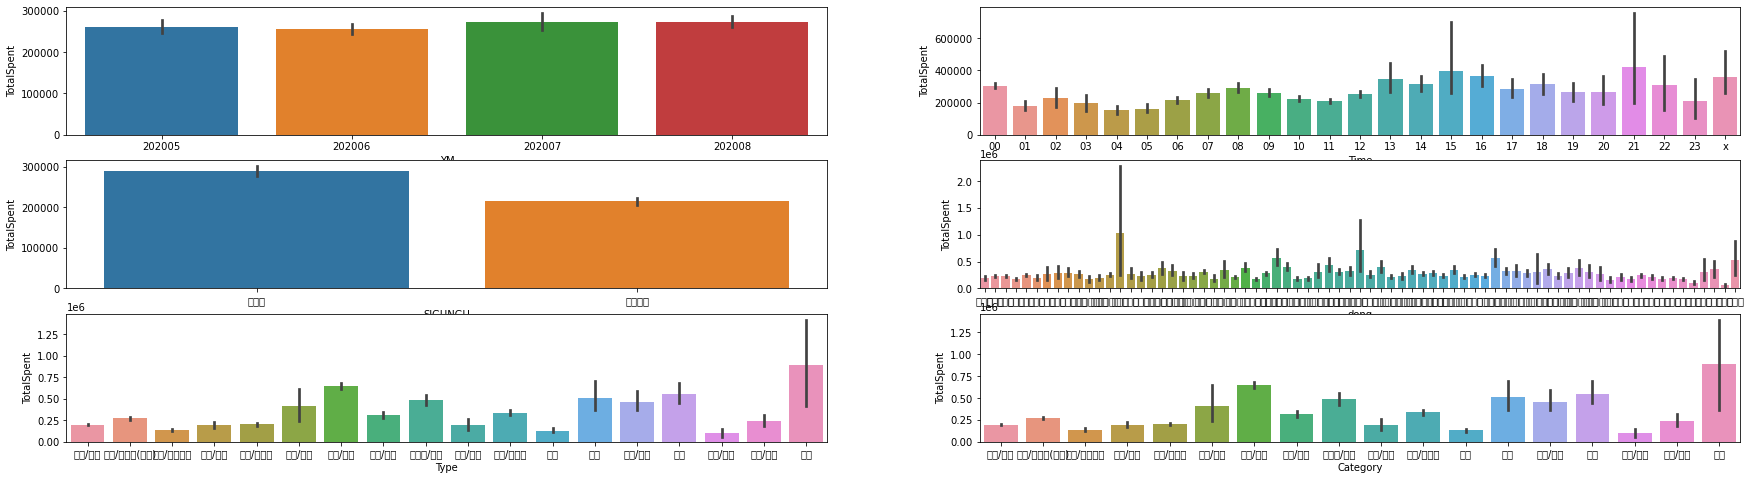

In [12]:
# 총사용금액으로 각 컬럼별 데이터 분석 

figure, ((ax1,ax2), (ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(30,8)

sns.barplot(data=jeju_all, x="YM", y="TotalSpent", ax=ax1)  #월별 총사용금액 
sns.barplot(data=jeju_all, x="Time", y="TotalSpent", ax=ax2)  #시간대별 총 사용금액 
sns.barplot(data=jeju_all, x="SIGUNGU", y="TotalSpent", ax=ax3) #제주/서귀포 총 사용금액
sns.barplot(data=jeju_all, x="dong", y="TotalSpent", ax=ax4) # 읍면동별 총 사용금액 
sns.barplot(data=jeju_all, x="Type", y="TotalSpent", ax=ax5) # 업종별 사용금액 
sns.barplot(data=jeju_all, x="Category", y="TotalSpent", ax=ax6) # 업종구분별 사용금액 